In [39]:
# ---------------------------------------------------------------------------
# 1) Imports
# ---------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.stats import norm
import time
import pandas as pd

In [40]:
# Import your modules
import os
os.chdir('/Users/jingyizhang/Desktop/MA4288O/deephedging/MA4288O-Project')

# Import your own modules:
from market.heston import HestonModel
# For the neural net strategies:
from utils.networks import RecurrentHedgeModel, SimpleHedgeModel
# For training loops & loss:
from optimizer.hedge_train import DeepHedgeCVaRTrainer  # or whatever class name you used
# from optimizer.loss_functions import cvar_loss  # if needed for direct calls
from payoff.european_option import european_call_payoff  # <-- IMPORTANT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [41]:
# ---------------------------------------------------------------------------
# 2) Black-Scholes Price and Delta Function
# ---------------------------------------------------------------------------
def black_scholes_call_price_delta(S0, K, T, sigma):
    d1 = (np.log(S0/K) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    price = S0*norm.cdf(d1) - K*norm.cdf(d2)
    delta = norm.cdf(d1)
    return price, delta

def compute_model_hedge_pnl(q, Z, delta_const, S_paths):
    S_diff = S_paths[:,1:] - S_paths[:,:-1]
    gains = delta_const * np.sum(S_diff, axis=1)
    pnl = q - Z + gains
    return pnl

def empirical_cvar(pnl, alpha=0.5):
    pnl_sorted = np.sort(pnl)
    idx = int(len(pnl) * alpha)
    return np.mean(pnl_sorted[:idx])

In [42]:
# ---------------------------------------------------------------------------
# 3) Simulation Setup
# ---------------------------------------------------------------------------
num_paths = 200_000
num_steps = 30
T = 30/365

heston = HestonModel(
    s0=100.0,
    v0=0.04,
    kappa=1.5,
    theta=0.04,
    xi=0.5,
    rho=-0.7,
    r=0.0,
    dt=T/num_steps,
    seed=1234
)

S_paths_np, V_paths_np = heston.simulate_paths(n_paths=num_paths, n_steps=num_steps)
Z_np = european_call_payoff(S_paths_np, K=100.0)

S_torch = torch.from_numpy(S_paths_np).float().to(device)
Z_torch = torch.from_numpy(Z_np).float().to(device)

In [43]:
sigma_guess = 0.2
q_bs, delta_bs = black_scholes_call_price_delta(100.0, 100.0, T, sigma_guess)

In [50]:
# ----------------------------------------------------------------------------
# 5) Train Recurrent Hedge under CVaR alpha=0.5
# ----------------------------------------------------------------------------
import torch

# Ensure tensors are on the correct device
S_torch = S_torch.to(device)
Z_torch = Z_torch.to(device)

# Define CVaR risk level
alpha = 0.5  

# Ensure num_steps is defined
num_steps = S_torch.shape[1] - 1  

# Initialize Recurrent Hedge Model (now using shared architecture)
recurrent_model = RecurrentHedgeModel(steps=num_steps, hidden_dim=32).to(device)

# Use the updated DeepHedgeCVaRTrainer
trainer_rec = DeepHedgeCVaRTrainer(
    # model=recurrent_model, 
    # loss_function="cvar", 
    alpha=alpha
)
trainer_rec = DeepHedgeCVaRTrainer(alpha=alpha)
trainer_rec.model = recurrent_model
trainer_rec.lr = 5e-3
# trainer_rec.n_epochs = 2
q_rec_bs, pnl_rec_bs, loss_history, q_history = trainer_rec.train(S_torch, Z_torch)


In [51]:
# ----------------------------------------------------------------------------
# 5) Train Simple Hedge
# ----------------------------------------------------------------------------
simple_model = SimpleHedgeModel(steps=steps, hidden_dim=16).to(device)
trainer_simp = DeepHedgeCVaRTrainer(alpha=alpha)
trainer_simp.model = simple_model
trainer_simp.lr = 5e-3
trainer_simp.n_epochs = 100
q_simp, pnl_simp, loss_simp, _ = trainer_simp.train(S_torch, Z_torch)

In [53]:
# ----------------------------------------------------------------------------
# 6) Metrics and Table
# ----------------------------------------------------------------------------
def empirical_cvar(pnl, alpha=0.5):
    pnl_sorted = np.sort(pnl)
    idx = int(len(pnl) * alpha)
    return np.mean(pnl_sorted[:idx])

results = {
    "Recurrent Hedge": {
        "pnl": pnl_rec_bs,
        "price": q_rec_bs
    },
    "Simple Hedge": {
        "pnl": pnl_simp,
        "price": q_simp
    }
}

for name, res in results.items():
    pnl = res["pnl"]
    res["mean"] = np.mean(pnl)
    res["std"] = np.std(pnl)
    res["mshe"] = np.mean(pnl**2)
    res["cvar"] = empirical_cvar(pnl)

summary_df = pd.DataFrame({
    name: {
        "Mean PnL": f"{res['mean']:.4f}",
        "Std PnL": f"{res['std']:.4f}",
        "MSHE": f"{res['mshe']:.4f}",
        "CVaR (0.5)": f"{res['cvar']:.4f}",
        "Price (q)": f"{res['price']:.4f}"
    }
    for name, res in results.items()
}).T

print("\n🔍 NN Architecture Comparison Metrics:\n")
print(summary_df)



🔍 NN Architecture Comparison Metrics:

                Mean PnL Std PnL     MSHE CVaR (0.5) Price (q)
Recurrent Hedge  -0.0000  4.1266  17.0285    -3.2676    2.2482
Simple Hedge      0.0000  5.1321  26.3388    -4.1186    2.2505


In [32]:
# ----------------------------------------------------------------------------
# 2) Simulation
# ----------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

T = 30 / 365
num_steps = 30
num_paths = 200_000
K = 100.0

heston = HestonModel(
    s0=100.0,
    v0=0.04,
    kappa=1.5,
    theta=0.04,
    xi=0.5,
    rho=-0.7,
    r=0.0,
    dt=T/num_steps,
    seed=42
)

S_paths_np, _ = heston.simulate_paths(n_paths=num_paths, n_steps=num_steps)
Z_np = european_call_payoff(S_paths_np, K=K)

S_torch = torch.from_numpy(S_paths_np).float().to(device)
Z_torch = torch.from_numpy(Z_np).float().to(device)


In [33]:
# ----------------------------------------------------------------------------
# 3) Model Hedge Price (for p0_init)
# ----------------------------------------------------------------------------
from scipy.stats import norm

def black_scholes_call_price(S0, K, T, sigma):
    d1 = (np.log(S0/K) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0 * norm.cdf(d1) - K * norm.cdf(d2)

q_bs = black_scholes_call_price(100.0, K, T, sigma=0.2)

In [57]:
# ----------------------------------------------------------------------------
# 4) Train Recurrent Hedge
# ----------------------------------------------------------------------------
alpha = 0.5
steps = S_torch.shape[1] - 1

recurrent_model = RecurrentHedgeModel(steps=steps, hidden_dim=64).to(device)
trainer_rec.n_epochs = 5
trainer_rec = DeepHedgeCVaRTrainer(alpha=alpha)
trainer_rec.model = recurrent_model
trainer_rec.lr = 1e-3
# trainer_rec.n_epochs = 2
q_rec, pnl_rec, loss_rec, _ = trainer_rec.train(S_torch, Z_torch)

In [58]:
# ----------------------------------------------------------------------------
# 5) Train Simple Hedge
# ----------------------------------------------------------------------------
simple_model = SimpleHedgeModel(steps=steps, hidden_dim=16).to(device)
trainer_simp = DeepHedgeCVaRTrainer(alpha=alpha)
trainer_simp.model = simple_model
trainer_simp.lr = 1e-3
trainer_simp.n_epochs = 5
q_simp, pnl_simp, loss_simp, _ = trainer_simp.train(S_torch, Z_torch)

In [59]:
# ----------------------------------------------------------------------------
# 6) Metrics and Table
# ----------------------------------------------------------------------------
def empirical_cvar(pnl, alpha=0.5):
    pnl_sorted = np.sort(pnl)
    idx = int(len(pnl) * alpha)
    return np.mean(pnl_sorted[:idx])

results = {
    "Recurrent Hedge": {
        "pnl": pnl_rec,
        "price": q_rec
    },
    "Simple Hedge": {
        "pnl": pnl_simp,
        "price": q_simp
    }
}

for name, res in results.items():
    pnl = res["pnl"]
    res["mean"] = np.mean(pnl)
    res["std"] = np.std(pnl)
    res["mshe"] = np.mean(pnl**2)
    res["cvar"] = empirical_cvar(pnl)

summary_df = pd.DataFrame({
    name: {
        "Mean PnL": f"{res['mean']:.4f}",
        "Std PnL": f"{res['std']:.4f}",
        "MSHE": f"{res['mshe']:.4f}",
        "CVaR (0.5)": f"{res['cvar']:.4f}",
        "Price (q)": f"{res['price']:.4f}"
    }
    for name, res in results.items()
}).T

print("\n🔍 NN Architecture Comparison Metrics:\n")
print(summary_df)



🔍 NN Architecture Comparison Metrics:

                Mean PnL Std PnL     MSHE CVaR (0.5) Price (q)
Recurrent Hedge   0.0000  3.2019  10.2520    -2.4447    2.2461
Simple Hedge     -0.0000  2.9914   8.9484    -2.2470    2.2455


In [60]:
def plot_side_by_side_hist(pnl1, pnl2, label1="Strategy A", label2="Strategy B",
                           bins=20, x_range=(-10, 10), title=None, save_path=None):
    """
    Plot side-by-side histograms for two PnL distributions with aligned bins.
    
    Args:
        pnl1, pnl2: numpy arrays of PnL values.
        label1, label2: labels for the two strategies.
        bins: number of histogram bins (default is 20 for wider bins).
        x_range: tuple, (min, max) for histogram x-axis.
        title: custom plot title. If None, generates one automatically.
        save_path: optional file path to save the plot.
    """
    counts1, edges = np.histogram(pnl1, bins=bins, range=x_range)
    counts2, _     = np.histogram(pnl2, bins=edges)

    centers = 0.5 * (edges[:-1] + edges[1:])
    width   = (edges[1] - edges[0]) / 3.0

    plt.figure(figsize=(10, 6))
    plt.bar(centers - width/2, counts1, width=width, alpha=0.6, label=label1, color='tab:blue')
    plt.bar(centers + width/2, counts2, width=width, alpha=0.6, label=label2, color='tab:orange')

    plt.xlabel("Terminal Hedging PnL", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.title(title or f"Side-by-side PnL Histogram: {label1} vs. {label2}")
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


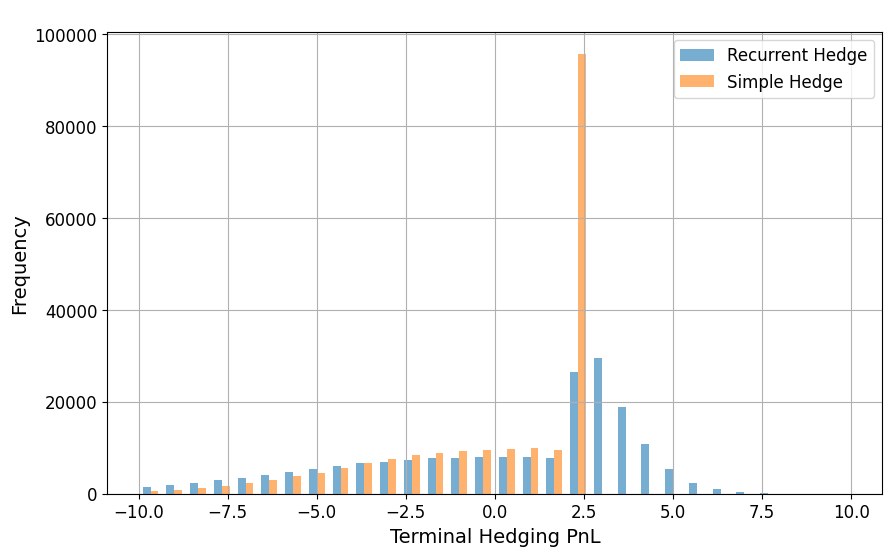

In [61]:
plot_side_by_side_hist(
    pnl1=pnl_rec_bs,
    pnl2=pnl_simp,
    label1="Recurrent Hedge",
    label2="Simple Hedge",
    bins=30,
    x_range=(-10, 10),
    title=" "
)